[BAŞLANGIÇ] Sistem: cuda
[BİLGİ] Veri okunuyor: /content/drive/MyDrive/Proje-doktora_1_1/DCRNN/metr-la.h5
[BİLGİ] Sensör Sayısı: 207 | Toplam Zaman Adımı: 34272
[İŞLEM] Pearson Korelasyon Matrisi oluşturuluyor...

>>> LSTM (Baseline) Eğitiliyor...
Epoch 005/100 | Train Loss: 0.2524 | Val Loss: 0.2353
Epoch 010/100 | Train Loss: 0.2409 | Val Loss: 0.2292
Epoch 015/100 | Train Loss: 0.2312 | Val Loss: 0.2302
Epoch 020/100 | Train Loss: 0.2275 | Val Loss: 0.2231
Epoch 025/100 | Train Loss: 0.2265 | Val Loss: 0.2225
Epoch 030/100 | Train Loss: 0.2233 | Val Loss: 0.2209
Epoch 035/100 | Train Loss: 0.2210 | Val Loss: 0.2241
Epoch 040/100 | Train Loss: 0.2198 | Val Loss: 0.2222
Epoch 045/100 | Train Loss: 0.2194 | Val Loss: 0.2191
Epoch 050/100 | Train Loss: 0.2187 | Val Loss: 0.2186
Epoch 055/100 | Train Loss: 0.2176 | Val Loss: 0.2207
Epoch 060/100 | Train Loss: 0.2181 | Val Loss: 0.2207
!! Erken Durdurma (Epoch 62)
>>> LSTM (Baseline) Bitti: MAE=4.40, MAPE=%9.46

>>> Cheb-LSTM Eğitiliyor..

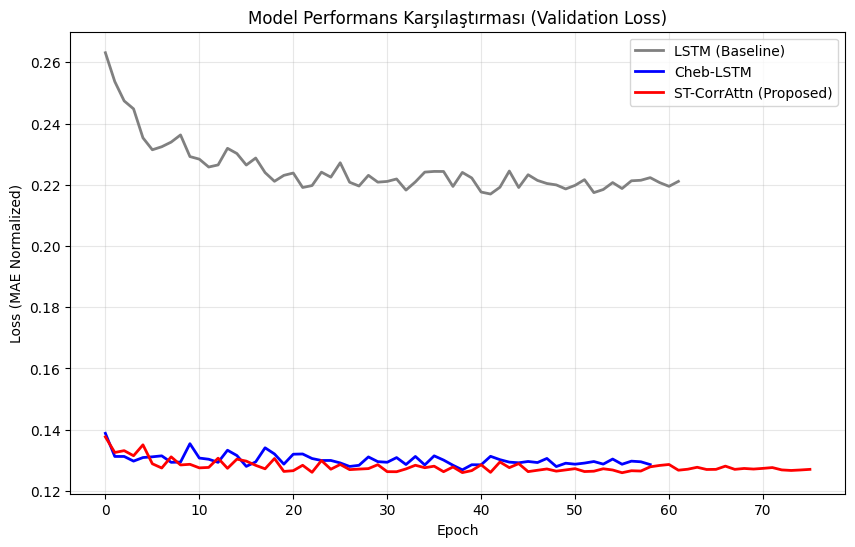

In [1]:
"""
ST-CorrAttn: Trafik Hız Tahmini İçin Uzamsal-Zamansal (Spatio-Temporal) Derin Öğrenme Modeli
=============================================================================================
Bu proje, kentsel trafik verilerini analiz ederek kısa vadeli trafik hızı tahmini yapar.
METR-LA veri seti üzerinde geliştirilmiştir.

Model Mimarisi ve Karşılaştırma:
Proje kapsamında üç farklı model eğitilip kıyaslanmaktadır:
1. LSTM (Baseline): Sadece zamansal ilişkilere bakar.
2. Cheb-LSTM: Graf konvolüsyonları ile uzamsal ilişkiyi de katar.
3. ST-CorrAttn (Önerilen): Pearson korelasyonu ve Attention mekanizması ile en gelişmiş modeldir.

Yazar: Enes Avcı
Yıl: 2026
Lisans: MIT
"""

import os
import time
import copy
import math
import random
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# =============================================================================
# 1. HİPERPARAMETRELER VE AYARLAR (CONFIG)
# =============================================================================
CONFIG = {
    'data_path': '/content/drive/MyDrive/Proje-doktora_1_1/DCRNN/metr-la.h5',  # Veri setinin yolu
    'seq_len': 12,        # Geçmiş 60 dakika (12 * 5dk)
    'horizon': 1,         # Gelecek 5 dakika
    'input_dim': 1,       # Sadece hız verisi
    'hidden_dim': 64,     # Gizli katman boyutu
    'dropout': 0.3,       # Dropout oranı
    'batch_size': 64,     # Batch boyutu
    'epochs': 100,         # Epoch sayısı
    'learning_rate': 1e-3,# Öğrenme hızı
    'patience': 20,       # Erken durdurma sabrı
    'k_order': 3,         # Chebyshev polinom derecesi
    'corr_threshold': 0.6,# Korelasyon eşik değeri
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

def seed_everything(seed=42):
    """Sonuçların her çalıştırmada aynı olması için rastgeleliği sabitler."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# =============================================================================
# 2. VERİ İŞLEME VE YÜKLEME SINIFI
# =============================================================================
class TrafficDataLoader:
    def __init__(self, data_path, seq_len=12, horizon=1, train_ratio=0.7):
        self.seq_len = seq_len
        self.horizon = horizon
        self.data_path = data_path
        self.train_ratio = train_ratio

        print(f"[BİLGİ] Veri okunuyor: {data_path}")
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"HATA: Belirtilen yolda dosya yok -> {data_path}")

        self.df = pd.read_hdf(data_path)
        self.data = self.df.values
        self.num_nodes = self.data.shape[1]
        self.num_samples = self.data.shape[0]

        # Normalizasyon (Z-Score)
        self.mean = self.data.mean()
        self.std = self.data.std()
        self.data_norm = (self.data - self.mean) / self.std

        self.split_idx = int(self.num_samples * self.train_ratio)
        print(f"[BİLGİ] Sensör Sayısı: {self.num_nodes} | Toplam Zaman Adımı: {self.num_samples}")

    def get_pearson_correlation_graph(self, threshold=0.5):
        """Trafik benzerliğine dayalı graf oluşturur (Pearson Korelasyonu)."""
        print("[İŞLEM] Pearson Korelasyon Matrisi oluşturuluyor...")
        train_df = self.df.iloc[:self.split_idx]
        corr_matrix = train_df.corr(method='pearson').values

        adj = np.abs(corr_matrix)
        adj[adj < threshold] = 0
        np.fill_diagonal(adj, 1.0)
        return adj

    def get_scaled_laplacian(self, adj):
        """Chebyshev GCN için normalize edilmiş Laplasyen matrisini hazırlar."""
        if not sp.isspmatrix(adj):
            adj = sp.coo_matrix(adj)

        d = np.array(adj.sum(1))
        d_inv_sqrt = np.power(d, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

        normalized_laplacian = sp.eye(adj.shape[0]) - d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)

        try:
            lambda_max, _ = eigs(normalized_laplacian, k=1, which='LM')
            lambda_max = lambda_max.real[0]
        except:
            lambda_max = 2.0

        L_tilde = (2 * normalized_laplacian / lambda_max) - sp.eye(adj.shape[0])
        return torch.FloatTensor(L_tilde.toarray())

    def get_iterator(self, type='train', batch_size=64):
        """Eğitim/Test verilerini batch'ler halinde sunar."""
        if type == 'train':
            data_source = self.data_norm[:self.split_idx]
        else:
            data_source = self.data_norm[self.split_idx:]

        num_samples = len(data_source) - self.seq_len - self.horizon
        indices = np.arange(num_samples)

        if type == 'train':
            np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i+batch_size]
            if len(batch_indices) < batch_size: continue

            X_batch, y_batch = [], []
            for idx in batch_indices:
                X_batch.append(data_source[idx : idx+self.seq_len])
                y_batch.append(data_source[idx+self.seq_len : idx+self.seq_len+self.horizon])

            yield torch.FloatTensor(np.array(X_batch)), torch.FloatTensor(np.array(y_batch))

# =============================================================================
# 3. MODEL KATMANLARI VE MİMARİLERİ
# =============================================================================

# --- YARDIMCI: Chebyshev Graf Konvolüsyonu ---
class ChebConvLayer(nn.Module):
    def __init__(self, in_features, out_features, k_order, L_tilde):
        super(ChebConvLayer, self).__init__()
        self.k_order = k_order
        self.L_tilde = L_tilde
        self.W = nn.Parameter(torch.FloatTensor(k_order * in_features, out_features))
        self.b = nn.Parameter(torch.FloatTensor(out_features))
        nn.init.xavier_uniform_(self.W)
        nn.init.constant_(self.b, 0.0)

    def forward(self, x):
        cheb_polys = [x]
        if self.k_order > 1:
            L = self.L_tilde.to(x.device)
            x1 = torch.matmul(L, x)
            cheb_polys.append(x1)
        for k in range(2, self.k_order):
            x_k = 2 * torch.matmul(L, cheb_polys[k-1]) - cheb_polys[k-2]
            cheb_polys.append(x_k)
        cheb_input = torch.cat(cheb_polys, dim=2)
        out = torch.matmul(cheb_input, self.W) + self.b
        return F.relu(out)

# --- MODEL 1: Saf LSTM (Baseline) ---
class Model_LSTM(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64, dropout=0.3):
        super(Model_LSTM, self).__init__()
        # Input size = num_nodes (Her sensör bir özellik gibi)
        self.lstm = nn.LSTM(input_size=num_nodes, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        # x shape: (Batch, Seq, Nodes) -> (Batch, Seq, Input_Size)
        # Sadece son boyutu kullanabilmek için squeeze yapıyoruz
        if x.dim() == 4: x = x.squeeze(-1)

        lstm_out, _ = self.lstm(x)
        last_step = self.dropout(lstm_out[:, -1, :])
        out = self.fc(last_step)
        return out

# --- MODEL 2: Cheb-LSTM (Uzamsal + Zamansal, Attention YOK) ---
class Model_ChebLSTM(nn.Module):
    def __init__(self, num_nodes, in_features, hidden_dim, L_tilde, k_order=3, dropout=0.3):
        super(Model_ChebLSTM, self).__init__()
        self.cheb_conv = ChebConvLayer(in_features, hidden_dim, k_order, L_tilde)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(-1)
        batch, seq, nodes, feat = x.shape

        # Uzamsal
        x_reshaped = x.view(batch * seq, nodes, feat)
        spatial_out = self.cheb_conv(x_reshaped)

        # Zamansal
        spatial_out = spatial_out.view(batch, seq, nodes, -1).permute(0, 2, 1, 3).contiguous().view(batch * nodes, seq, -1)
        _, (h_n, _) = self.lstm(spatial_out)

        last_hidden = self.dropout(h_n[-1])
        out = self.fc(last_hidden)
        return out.view(batch, nodes)

# --- MODEL 3: ST-CorrAttn (Bizim Önerdiğimiz Model) ---
class Model_CorrAttn_Net(nn.Module):
    def __init__(self, num_nodes, in_features, hidden_dim, L_tilde, k_order=3, dropout=0.3):
        super(Model_CorrAttn_Net, self).__init__()
        # 1. Uzamsal
        self.cheb_conv = ChebConvLayer(in_features, hidden_dim, k_order, L_tilde)

        # 2. Zamansal
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # 3. Attention
        self.W_a = nn.Linear(hidden_dim, hidden_dim)
        self.v_a = nn.Linear(hidden_dim, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1) # Context + Hidden

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(-1)
        batch, seq, nodes, feat = x.shape

        # Uzamsal GCN
        x_reshaped = x.view(batch * seq, nodes, feat)
        spatial_out = self.cheb_conv(x_reshaped)

        # Zamansal LSTM
        lstm_input = spatial_out.view(batch, seq, nodes, -1).permute(0, 2, 1, 3).contiguous().view(batch * nodes, seq, -1)
        lstm_out, (h_n, _) = self.lstm(lstm_input)

        # Attention
        energy = torch.tanh(self.W_a(lstm_out))
        scores = self.v_a(energy)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        # Çıktı
        last_hidden = h_n[-1]
        context = self.dropout(context)
        last_hidden = self.dropout(last_hidden)

        combined = torch.cat([context, last_hidden], dim=1)
        out = self.fc(combined)
        return out.view(batch, nodes)

# =============================================================================
# 4. EĞİTİM MOTORU
# =============================================================================
def train_engine(model, loader, device, epochs=50, model_name="Model"):
    print(f"\n{'='*20}\n>>> {model_name} Eğitiliyor...\n{'='*20}")
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.L1Loss()

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_weights = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for x_batch, y_batch in loader.get_iterator('train', batch_size=CONFIG['batch_size']):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # LSTM modeli için boyut düzeltmesi (Diğerleri 4D beklerken o 3D istiyor)
            if model_name == "LSTM (Baseline)":
                 x_batch = x_batch.squeeze(-1) if x_batch.dim() == 4 else x_batch

            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch[:, 0, :])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_train_loss = np.mean(batch_losses)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for x_batch, y_batch in loader.get_iterator('test', batch_size=CONFIG['batch_size']):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if model_name == "LSTM (Baseline)":
                     x_batch = x_batch.squeeze(-1) if x_batch.dim() == 4 else x_batch

                preds = model(x_batch)
                loss = criterion(preds, y_batch[:, 0, :])
                val_batch_losses.append(loss.item())

        epoch_val_loss = np.mean(val_batch_losses)
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['patience']:
                print(f"!! Erken Durdurma (Epoch {epoch+1})")
                break

    model.load_state_dict(best_weights)
    return train_losses, val_losses

def evaluate_metrics(model, loader, device, model_name="Model"):
    model.eval()
    preds_list, true_list = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader.get_iterator('test', batch_size=CONFIG['batch_size']):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if model_name == "LSTM (Baseline)":
                 x_batch = x_batch.squeeze(-1) if x_batch.dim() == 4 else x_batch

            preds = model(x_batch)
            preds_list.append(preds.cpu().numpy())
            true_list.append(y_batch[:, 0, :].cpu().numpy())

    y_pred = np.concatenate(preds_list, axis=0)
    y_true = np.concatenate(true_list, axis=0)

    # Ters Normalizasyon (Gerçek birime dönüş)
    y_pred = y_pred * loader.std + loader.mean
    y_true = y_true * loader.std + loader.mean
    mask = y_true > 1.0

    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    mape = np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100
    return mae, rmse, mape

# =============================================================================
# 5. ANA ÇALIŞTIRMA (MAIN)
# =============================================================================
if __name__ == "__main__":
    print(f"[BAŞLANGIÇ] Sistem: {CONFIG['device']}")

    if os.path.exists(CONFIG['data_path']):
        loader = TrafficDataLoader(CONFIG['data_path'], seq_len=CONFIG['seq_len'], horizon=CONFIG['horizon'])

        # Pearson Korelasyon Matrisi
        adj_mx = loader.get_pearson_correlation_graph(threshold=CONFIG['corr_threshold'])
        L_tilde = loader.get_scaled_laplacian(adj_mx).to(CONFIG['device'])

        # --- TÜM MODELLERİN LİSTESİ ---
        models_to_train = [
            ("LSTM (Baseline)", Model_LSTM(
                loader.num_nodes,
                hidden_dim=CONFIG['hidden_dim'],
                dropout=CONFIG['dropout']
            ).to(CONFIG['device'])),

            ("Cheb-LSTM", Model_ChebLSTM(
                loader.num_nodes,
                in_features=CONFIG['input_dim'],
                hidden_dim=CONFIG['hidden_dim'],
                L_tilde=L_tilde,
                dropout=CONFIG['dropout']
            ).to(CONFIG['device'])),

            ("ST-CorrAttn (Proposed)", Model_CorrAttn_Net(
                loader.num_nodes,
                in_features=CONFIG['input_dim'],
                hidden_dim=CONFIG['hidden_dim'],
                L_tilde=L_tilde,
                dropout=CONFIG['dropout']
            ).to(CONFIG['device']))
        ]

        results = {"Model": [], "MAE": [], "RMSE": [], "MAPE": [], "Loss_History": []}

        # --- DÖNGÜ: HEPSİNİ EĞİT VE KARŞILAŞTIR ---
        for name, model in models_to_train:
            _, val_losses = train_engine(model, loader, CONFIG['device'], epochs=CONFIG['epochs'], model_name=name)
            mae, rmse, mape = evaluate_metrics(model, loader, CONFIG['device'], model_name=name)

            results["Model"].append(name)
            results["MAE"].append(mae)
            results["RMSE"].append(rmse)
            results["MAPE"].append(mape)
            results["Loss_History"].append(val_losses)
            print(f">>> {name} Bitti: MAE={mae:.2f}, MAPE=%{mape:.2f}")

        # SONUÇ TABLOSU
        print("\n" + "="*60)
        print(f"{'MODEL':<25} | {'MAE':<8} | {'RMSE':<8} | {'MAPE':<8}")
        print("-" * 60)
        for i in range(len(results["Model"])):
            print(f"{results['Model'][i]:<25} | {results['MAE'][i]:.3f}    | {results['RMSE'][i]:.3f}    | {results['MAPE'][i]:.2f}%")
        print("="*60)

        # KARŞILAŞTIRMA GRAFİĞİ
        plt.figure(figsize=(10, 6))
        colors = ['gray', 'blue', 'red']
        for i, hist in enumerate(results["Loss_History"]):
            plt.plot(hist, label=results["Model"][i], color=colors[i], linewidth=2)
        plt.title("Model Performans Karşılaştırması (Validation Loss)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (MAE Normalized)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    else:
        print("[HATA] Veri dosyası bulunamadı.")